In [1]:
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [2]:
'''
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow-text

# You will use the AdamW optimizer from tensorflow/models.
!pip install tf-models-official
'''

'\n# A dependency of the preprocessing for BERT inputs\n!pip install tensorflow-text\n\n# You will use the AdamW optimizer from tensorflow/models.\n!pip install tf-models-official\n'

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Alienware\miniconda3\envs\py309\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [4]:
'''
Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database.

Download the IMDB dataset
Let's download and extract the dataset, then explore the directory structure.
'''

"\nSentiment analysis\nThis notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.\n\nYou'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database.\n\nDownload the IMDB dataset\nLet's download and extract the dataset, then explore the directory structure.\n"

In [5]:
# url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
#                                   untar=True, cache_dir=os.path.abspath('.'),
#                                   cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# train_dir = os.path.join(dataset_dir, 'train')

# # remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [6]:
'''
Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. 
Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, 
so that the validation and training splits have no overlap.
'''

"\nNext, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.\n\nThe IMDB dataset has already been divided into train and test, but it lacks a validation set. \nLet's create a validation set using an 80:20 split of the training data by using the validation_split argument below.\n\nNote: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, \nso that the validation and training splits have no overlap.\n"

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.abspath('aclImdb/train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed) #The seed argument ensures that the data is split, without duplicating data, in both the training and validation datasets (see below)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('train dataset created')

'''
cache() keeps the data in memory after it’s loaded off disk. 
This ensures the dataset does not have to read from disk on each epoch. 
This can be particularly beneficial if the dataset fits into memory.

prefetch(buffer_size) overlaps the preprocessing and model execution of a training step.
While the model is executing training step s, the input pipeline is reading the data for step s+1. 
This can improve latency and throughput, at the cost of using additional memory to store prefetched data.
'''

val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.abspath('aclImdb/train'),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)  #The seed argument ensures that the data is split, without duplicating data, in both the training and validation datasets (see above)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('validation dataset created')

test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.abspath('aclImdb/test'),
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('test dataset created')


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
train dataset created
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
validation dataset created
Found 25000 files belonging to 2 classes.
test dataset created


In [8]:
# Let's take a look at a few reviews.

for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [9]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

'''
In the context of TensorFlow Hub, a “handle” is a string that identifies a specific model. 
It can be a URL or a local file path

The BERT encoder handle identifies the BERT model itself. 
This is the part of the model that takes tokenized text as input and produces embeddings (dense vector representations) as output.

The BERT preprocessing model handle identifies the model or function that preprocesses text data 
to make it suitable for input to the BERT model. This preprocessing typically includes tokenization and other transformations.
'''

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
'''
The preprocessing model
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. 
TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, 
which implements this transformation using TF ops from the TF.text library. 
It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, 
which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a hub.KerasLayer to compose your fine-tuned model. 
This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.
'''

'\nThe preprocessing model\nText inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. \nTensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, \nwhich implements this transformation using TF ops from the TF.text library. \nIt is not necessary to run pure Python code outside your TensorFlow model to preprocess text.\n\nThe preprocessing model must be the one referenced by the documentation of the BERT model, \nwhich you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.\n\nNote: You will load the preprocessing model into a hub.KerasLayer to compose your fine-tuned model. \nThis is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.\n'

In [11]:
'''
CHECKING PRE-PROCESS
'''

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# Let's try the preprocessing model on some text and see the output:

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')

print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')

print(f'Input Mask : {text_preprocessed["input_mask"]}')

print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

'''
As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).

Some other important points:

The input is truncated to 128 tokens. The number of tokens can be customized, 
and you can see more details on the Solve GLUE tasks using BERT on a TPU colab.
The input_type_ids only have one value (0) because this is a single sentence input. 
For a multiple sentence input, it would have one number for each input.
Since this text preprocessor is a TensorFlow model, It can be included in your model directly.
'''

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [[ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 

'\nAs you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).\n\nSome other important points:\n\nThe input is truncated to 128 tokens. The number of tokens can be customized, \nand you can see more details on the Solve GLUE tasks using BERT on a TPU colab.\nThe input_type_ids only have one value (0) because this is a single sentence input. \nFor a multiple sentence input, it would have one number for each input.\nSince this text preprocessor is a TensorFlow model, It can be included in your model directly.\n'

In [12]:
'''
CHECKING ENCODER

Using the BERT model
Before putting BERT into your own model, let's take a look at its outputs. 
You will load it from TF Hub and see the returned values.
'''

bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"]}')

print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"]}')

print(f'Encoder Outputs Layers:{len(bert_results["encoder_outputs"])}')
print(f'Encoder Outputs Layer Shape:{bert_results["encoder_outputs"][-1].shape}')
print(f'Sequence Outputs Layer:{bert_results["encoder_outputs"][-1]}')

'''

In the BERT model name ‘bert_en_uncased_L-4_H-512_A-8/1’, ‘L’, ‘H’, and ‘A’ stand for the following parameters of the model architecture:

L: The number of transformer layers (i.e., transformer blocks) in the BERT model. In this case, ‘L-4’ means the model has 4 layers.
H: The hidden size, which is the dimensionality of the hidden states in the transformer layers. Here, ‘H-512’ means the hidden size is 512.
A: The number of attention heads in the self-attention mechanism of each transformer layer. ‘A-8’ indicates that there are 8 attention heads.

So, ‘bert_en_uncased_L-4_H-512_A-8/1’ refers to a version of BERT that is English (en), uncased, 
has 4 transformer layers, a hidden size of 512, and 8 attention heads.
The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

-----

pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. 
In the context of the model name "bert_en_uncased_L-4_H-512_A-8/1," the "H" stands for "hidden size."
The "hidden size" refers to the dimensionality of the hidden states in the transformer model. 
In this case, the hidden size is set to 512, meaning that each hidden state in the model has a dimensionality of 512
You can think of pooled_output as an embedding for the entire movie review.

sequence_output represents each input token in the context. The shape is [batch_size=1, seq_length=128, H=512]. 
The sequence length represents the input number of token (the shape of the input_word_ids: 128)
You can think of sequence_output as a contextual embedding for every token in the movie review.

encoder_outputs are the intermediate activations of the L Transformer blocks. 
outputs["encoder_outputs"][i] is a Tensor of shape [batch_size=1, seq_length=128, H=512] 
with the outputs of the i-th Transformer block, for 0 <= i < L. 
The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the pooled_output array.
'''

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[[ 7.62628317e-01  9.92809832e-01 -1.86118737e-01  3.66738528e-01
   1.52336732e-01  6.55044675e-01  9.68115389e-01 -9.48627114e-01
   2.16190517e-03 -9.87773180e-01  6.84275031e-02 -9.76306081e-01
   2.99960196e-01 -9.99825835e-01  2.18228668e-01  4.57802355e-01
   1.28510416e-01  2.62947232e-01 -4.03386742e-01 -1.70664623e-01
   1.30039886e-01 -1.20207846e-01 -9.34154928e-01  2.52413988e-01
   9.80566800e-01  9.85106587e-01 -3.83478463e-01 -6.19303435e-02
   3.53126645e-01  9.61802423e-01  4.37849164e-01 -7.62055591e-02
   3.83451641e-01 -3.99952859e-01  3.88874263e-01 -7.05706775e-02
  -1.84964299e-01 -3.74650866e-01 -8.90866280e-01 -2.45328590e-01
   1.48203382e-02 -4.44232635e-02  8.27981904e-02 -6.79375291e-01
   1.38857380e-01 -9.11613479e-02 -9.95979846e-01  2.31295943e-01
   2.47622654e-01 -3.34113657e-01  9.97976243e-01 -3.57811093e-01
   9.

'\n\nIn the BERT model name ‘bert_en_uncased_L-4_H-512_A-8/1’, ‘L’, ‘H’, and ‘A’ stand for the following parameters of the model architecture:\n\nL: The number of transformer layers (i.e., transformer blocks) in the BERT model. In this case, ‘L-4’ means the model has 4 layers.\nH: The hidden size, which is the dimensionality of the hidden states in the transformer layers. Here, ‘H-512’ means the hidden size is 512.\nA: The number of attention heads in the self-attention mechanism of each transformer layer. ‘A-8’ indicates that there are 8 attention heads.\n\nSo, ‘bert_en_uncased_L-4_H-512_A-8/1’ refers to a version of BERT that is English (en), uncased, \nhas 4 transformer layers, a hidden size of 512, and 8 attention heads.\nThe BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:\n\n-----\n\npooled_output represents each input sequence as a whole. The shape is [batch_size, H]. \nIn the context of the model name "bert_en_uncased_L-4_H-512_A-

In [13]:
'''
Define your model
You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. 
Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.
'''

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
# Let's check that the model runs with the output of the preprocessing model.

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result)) # note that the signmoid activation functions is used here, instead that on the last layer of the model

# The output is meaningless, of course, because the model has not been trained yet.


tf.Tensor([[0.19837682]], shape=(1, 1), dtype=float32)


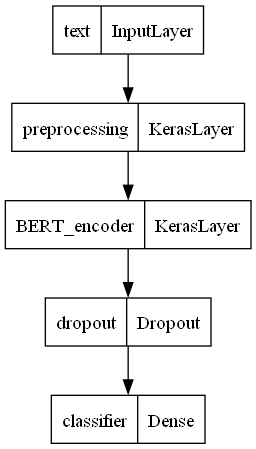

In [15]:
# Let's take a look at the model's structure.

tf.keras.utils.plot_model(classifier_model)

In [17]:
'''
Model training
You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

Loss function
Since this is a binary classification problem and the model outputs a probability (a single-unit layer), 
you'll use losses.BinaryCrossentropy loss function.
'''

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [18]:
'''
Optimizer
For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). 
This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments (?)), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: 
linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). 
In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).
'''

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() #  number of batches in the train_ds dataset: 625
# as the batch size is set to 32, and there are 20.000 samples in the train dataset, then the number of batches in the train_ds dataset: 625
num_train_steps = steps_per_epoch * epochs # total number of weights update
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [24]:
'''
Loading the BERT model and training
Using the classifier_model you created earlier, you can compile the model with the loss, metric and optimizer.
'''

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Note: training time will vary depending on the complexity of the BERT model you have selected.

print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 236s 364ms/step - loss: 0.4878 - binary_accuracy: 0.7455 - val_loss: 0.4046 - val_binary_accuracy: 0.8352
Epoch 2/5
625/625 [==============================] - 220s 352ms/step - loss: 0.3335 - binary_accuracy: 0.8510 - val_loss: 0.3684 - val_binary_accuracy: 0.8462
Epoch 3/5
625/625 [==============================] - 236s 378ms/step - loss: 0.2552 - binary_accuracy: 0.8906 - val_loss: 0.3985 - val_binary_accuracy: 0.8496
Epoch 4/5
625/625 [==============================] - 240s 384ms/step - loss: 0.1908 - binary_accuracy: 0.9231 - val_loss: 0.4676 - val_binary_accuracy: 0.8490
Epoch 5/5
625/625 [==============================] - 238s 381ms/step - loss: 0.1547 - binary_accuracy: 0.9404 - val_loss: 0.4787 - val_binary_accuracy: 0.8504


In [25]:
'''
Evaluate the model
Let's see how the model performs. 
Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.
'''

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 259s 328ms/step - loss: 0.4608 - binary_accuracy: 0.8550
Loss: 0.4608355462551117
Accuracy: 0.8550400137901306


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


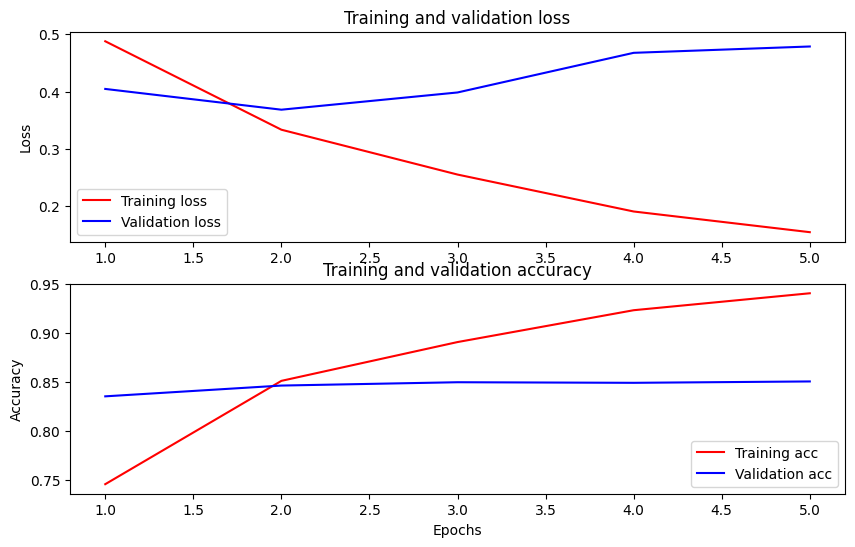

In [26]:
'''
Plot the accuracy and loss over time
Based on the History object returned by model.fit(). 
You can plot the training and validation loss for comparison, as well as the training and validation accuracy:
'''

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
# Export for inference
# Now you just save your fine-tuned model for later use.


dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)
# If you plan to continue training this model later, you might want to save the optimizer’s state as well. 
# However, if you’re only interested in deploying the model for inference, you don’t need to save the optimizer’s state.

In [28]:
# Let's reload the model, so you can try it side by side with the model that is still in memory.

reloaded_model = tf.saved_model.load(saved_model_path)

In [31]:
# Here you can test your model on any sentence you want, just add to the examples variable below.


def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'I would''nt need to watch it again to be able to evaluate it',
    'I''d say not bad, not good',
    'I''d say not too bad, but not good'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999723
input: The movie was great!           : score: 0.998469
input: The movie was meh.             : score: 0.934831
input: The movie was okish.           : score: 0.037974
input: The movie was terrible...      : score: 0.001584
input: I wouldnt need to watch it again to be able to evaluate it : score: 0.325776
input: Id say not bad, not good       : score: 0.043970
input: Id say not too bad, but not good : score: 0.117230

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999723
input: The movie was great!           : score: 0.998469
input: The movie was meh.             : score: 0.934831
input: The movie was okish.           : score: 0.037974
input: The movie was terrible...      : score: 0.001584
input: I wouldnt need to watch it again to be able to evaluate it : score: 0.325776
input: Id say not bad, not good       : score: 0.043970
input: Id say not too bad, but not go

In [32]:
# If you want to use your model on TF Serving, remember that it will call your SavedModel through one of its named signatures.
# In Python, you can test them as follows:

serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999723
input: The movie was great!           : score: 0.998469
input: The movie was meh.             : score: 0.934831
input: The movie was okish.           : score: 0.037974
input: The movie was terrible...      : score: 0.001584
input: I wouldnt need to watch it again to be able to evaluate it : score: 0.325776
input: Id say not bad, not good       : score: 0.043970
input: Id say not too bad, but not good : score: 0.117230

